In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
hospital_data = pd.read_csv('data/vetinary_hospital_data.csv')

geo_data = gpd.read_file('data/district.geojson')

In [27]:
# Step 1: Create a complete grid of districts and hospital types
all_districts = hospital_data['District'].unique()
all_hospital_types = hospital_data['Hospital Type'].unique()

# Create a DataFrame from a Cartesian product of these two arrays
from itertools import product
all_combinations = pd.DataFrame(product(all_districts, all_hospital_types), columns=['District', 'Hospital Type'])

# Step 2: Merge with your existing data (e.g., hospital_counts)
# Ensure hospital_counts is your data aggregated with counts
hospital_counts = hospital_data.groupby(['District', 'Hospital Type']).size().reset_index(name='Count')
complete_data = all_combinations.merge(hospital_counts, on=['District', 'Hospital Type'], how='left')

# Step 3: Fill missing values with 0
complete_data['Count'] = complete_data['Count'].fillna(0)

# Now, complete_data has all districts with each hospital type, with 0 where there's no such hospital

In [28]:
merged_data = geo_data.merge(complete_data, left_on='DISTRICT', right_on='District')

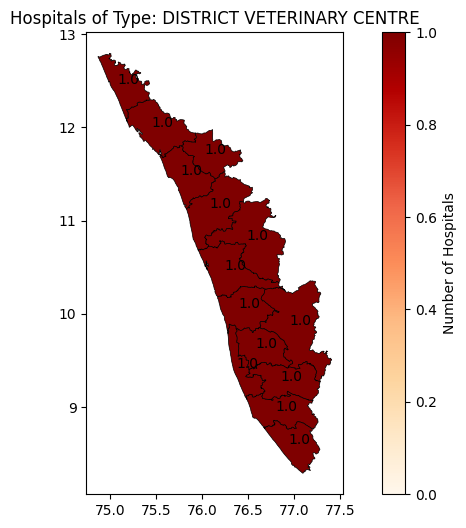

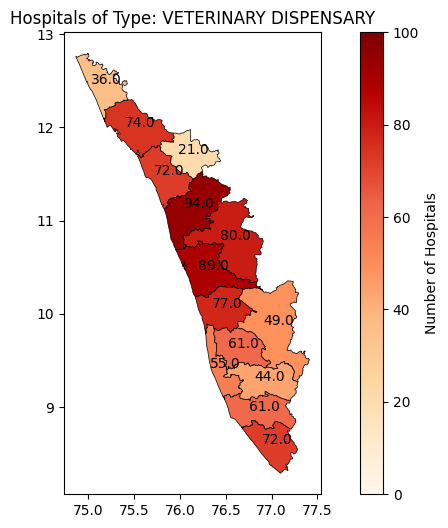

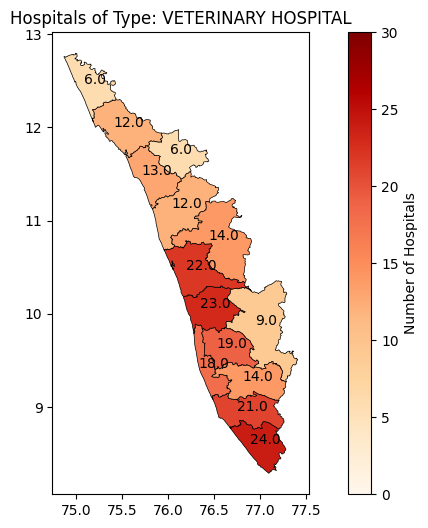

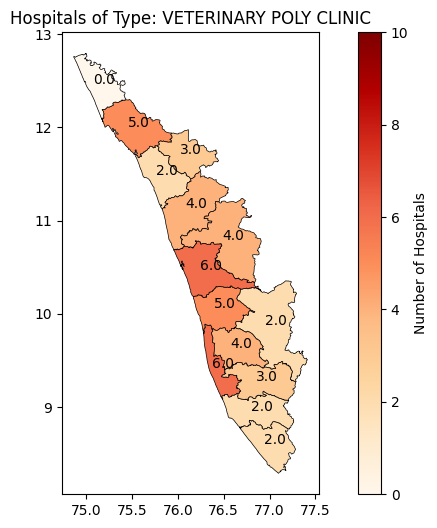

In [31]:
for hospital_type in hospital_data['Hospital Type'].unique():
    if(hospital_type == 'VETERINARY DISPENSARY'):
        min_value = 0
        max_value = 100
    elif(hospital_type == 'VETERINARY HOSPITAL'):
        min_value = 0
        max_value = 30
    elif(hospital_type == 'VETERINARY POLY CLINIC'):
        min_value = 0
        max_value = 10
    else:
        min_value = 0
        max_value = 1
    # Filter the data
    filtered_data = merged_data[merged_data['Hospital Type'] == hospital_type]
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    filtered_data.plot(column='Count', ax=ax, legend=True,
                       edgecolor='black',  # Set the color of the borders
                       linewidth=0.5,
                       vmin=min_value, vmax=max_value,
                       legend_kwds={'label': "Number of Hospitals"},
                       cmap='OrRd')
    for idx, row in filtered_data.iterrows():
        centroid = row.geometry.centroid
        ax.annotate(text=row['Count'], xy=(centroid.x, centroid.y),
                    xytext=(3, 3), textcoords="offset points",
                    ha='center', va='center')

    plt.title(f'Hospitals of Type: {hospital_type}')
    plt.show()

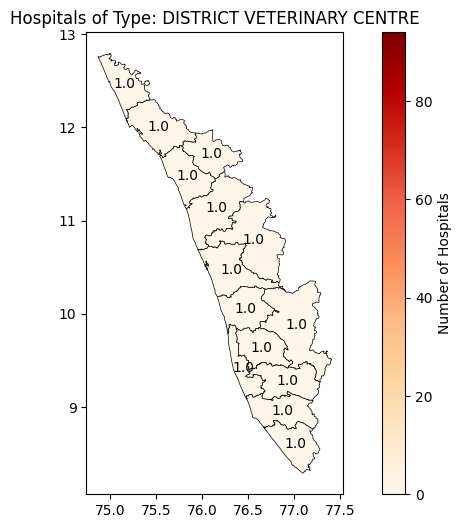

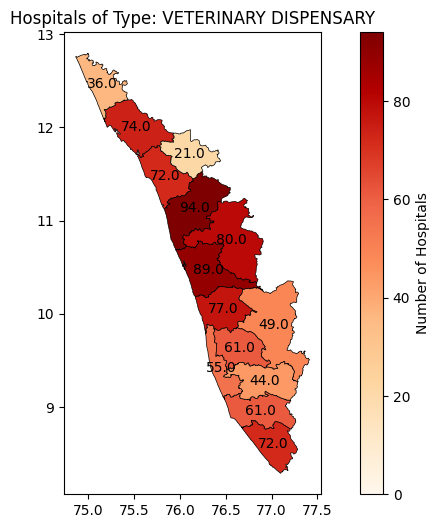

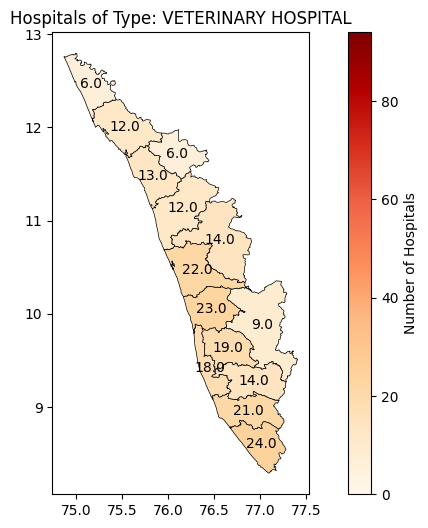

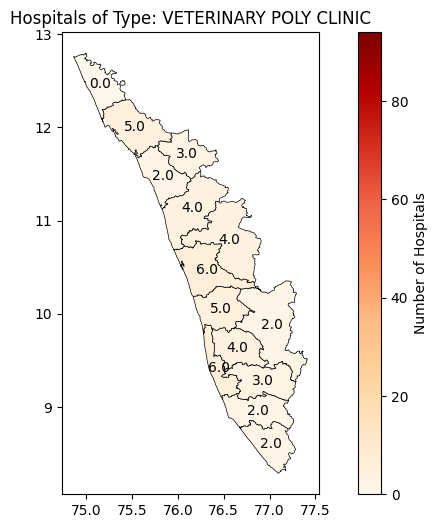

In [37]:
import folium

# Define the latitude and longitude for the center of Kerala
# These coordinates are approximate and can be adjusted to your preference
latitude = 10.8505
longitude = 76.2711

# Create a base map
m = folium.Map(location=[latitude, longitude], zoom_start=7)  # Adjust zoom_start as needed

# Add layers for each hospital type
for hospital_type in hospital_data['Hospital Type'].unique():
    # Filter the data
    filtered_data = merged_data[merged_data['Hospital Type'] == hospital_type]

    # Create a GeoJson layer and add it to the map
    folium.GeoJson(filtered_data, 
                   name=hospital_type,
                   style_function=lambda feature: {
                        'fillColor': 'green',  # You can use different colors or styles
                        'color': 'black',
                        'weight': 2,
                        'dashArray': '5, 5'
                    }).add_to(m)

# Add layer control and display the map
folium.LayerControl().add_to(m)
m
